In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytides.tide import Tide
from datetime import datetime
from scipy.optimize import curve_fit
import matplotlib.dates as dates
from scipy import signal
from scipy import stats

Tide gauge data from Nain, Nunatsiavut; 1963-2018; hourly intervals; access here: http://uhslc.soest.hawaii.edu/data/?rq#uh833a

Here, we load the data from the csv file, identify NaN values, convert columns to datetime format, and display the data:

In [9]:
gage_data = pd.read_csv('h833a.csv', parse_dates=True)
#gage_data.head()

In [10]:
# replace missing values w NaN

gage_data = gage_data.replace(-32767, np.NaN)

In [11]:
# convert to datetime format

timeseries = pd.to_datetime(gage_data[['year', 'month', 'day', 'hour']])

# add datetime object to DataFrame
# and reindex by datetime

gage_data['datetime'] = timeseries
#gage_data = gage_data.set_index('datetime')

gage_data.head()

,year,month,day,hour,height,datetime
0,1963,10,17,5,530.0,1963-10-17 05:00:00
1,1963,10,17,6,650.0,1963-10-17 06:00:00
2,1963,10,17,7,970.0,1963-10-17 07:00:00
3,1963,10,17,8,1380.0,1963-10-17 08:00:00
4,1963,10,17,9,1870.0,1963-10-17 09:00:00


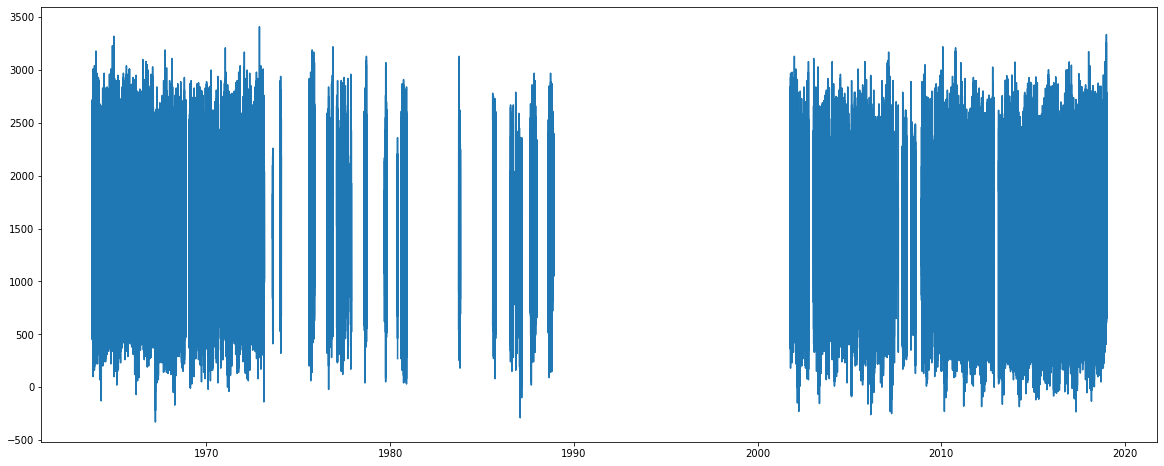

In [12]:
# plot the data

fig, ax = plt.subplots(figsize=(20,8))

ax.plot(gage_data['datetime'], gage_data['height'])

plt.show()

The goal is to deconstruct the tide gauge data into the contributing components: __$h(t) = h_0 + h_{trend} + h_{tide} +h'$__

where,

>$h_0$ is the mean

>$h_{trend}$ is the trend over time (i.e., sea level change)

>$h_{tide}$ is the sum of the tidal components 

>$h'$ is everything else (e.g., storm surges)

***

First, we calculate $h_0$ and subtract it from the data:

In [13]:
# find the mean for the entire array

h_0 = np.mean(gage_data['height'])
#h_0 

# h_0 = 1431.1514184840478

In [14]:
# subtract h_0 from each value in array
# create new array h_mean_corr with corrected values

h_mean_corr = gage_data['height']-h_0

# add mean corrected gage heights to the DataFrame
gage_data['h_mean_corr'] = h_mean_corr

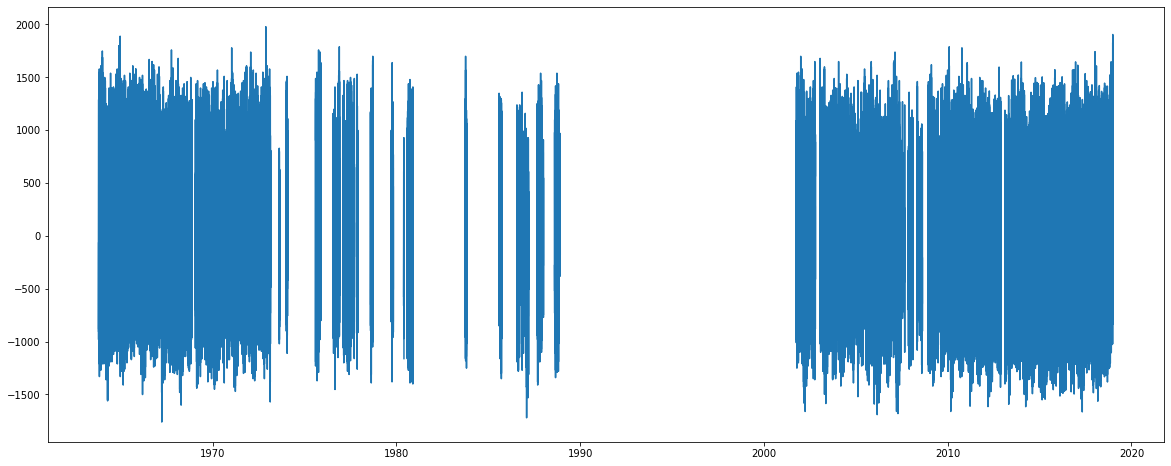

In [15]:
# check that the data is centered on 0

fig, ax = plt.subplots(figsize=(20,8))

ax.plot(gage_data['datetime'], gage_data['h_mean_corr'])

plt.show()

***

Next, we detrend the data by finding the best fit trend line to the timeseries of gauge height using a linear equation.

In [61]:
# store the ydata in a numpy array

y_height = gage_data['h_mean_corr']

In [77]:
# curve_fit does not work on datetime objects
# workaround: date2num function ~ much easier than creating a new array w np.linspace!
# code: https://stackoverflow.com/questions/70852986/add-trend-line-to-datetime-matplotlib-line-graph

x_num = dates.date2num(gage_data['datetime'])

In [80]:
# Apply a boolean mask to both arrays saying: valid data are not (~) NaN
# Code source: https://stackoverflow.com/questions/33876226/scipy-curve-fit-fails-on-easy-linear-fit

valid = ~(np.isnan(x_num) | np.isnan(y_height))

Realizing in hindsight that i could have substituted scipy. stats.linregress for defining a linear function to skip several steps... i checked it with that function and the parameters it returns are identical. if we publish a notebook with this, i will change the code to use that function for simplicity.

In [81]:
# define a function 
# linear change in x with b intercept

def linear_fit(x, m, b):
    """Calculate linear change in *x*
    
    Parameters
    ----------
    x : float ndarray
        The x-values.
    m : float or 1-element float ndarray
        The rate of growth.
    b : float or 1-element float ndarray
        The intercept.
    
    Returns
    -------
    float ndarray
        The fitted y-values.
    
    """
    return m * x + b

In [82]:
# run scipy.optimize curve fitting function on the x,y data 
# curve_fit(function, xdata, ydata)

popt, pcov = curve_fit(linear_fit, x_num[valid], y_height[valid])

# print the parameters m, b
popt

array([-6.07133157e-03,  4.41854089e+03])

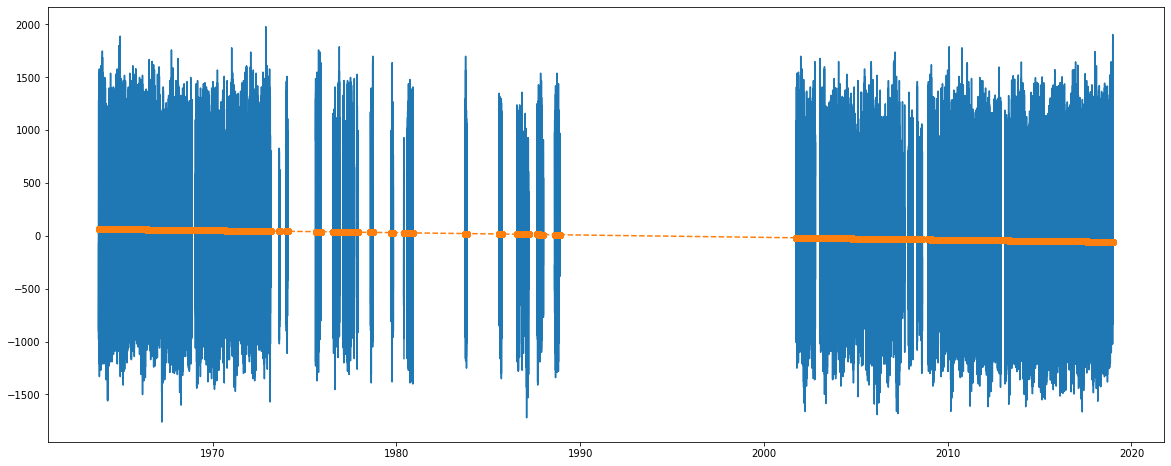

In [136]:
# display the data along with the trend line
# this plot ignores NaN values in order to bypass plotting datetime objects

fig, ax = plt.subplots(figsize=(20,8))

ax.plot(gage_data['datetime'], gage_data['h_mean_corr'])

ax.plot(x_num[valid], linear_fit(x_num[valid], *popt), '--o',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

plt.show()

With the parameters for the trend line defined, the next step is to calculate values of $h_{trend}$ and subtract them from the mean corrected values for $h$.

In [95]:
h_tr = signal.detrend(y_height[valid])

I found the scipy.signal.detrend function and decided to try it out. It looks about right, but doesn't handle the NaNs either, so I'll manually detrend it instead.

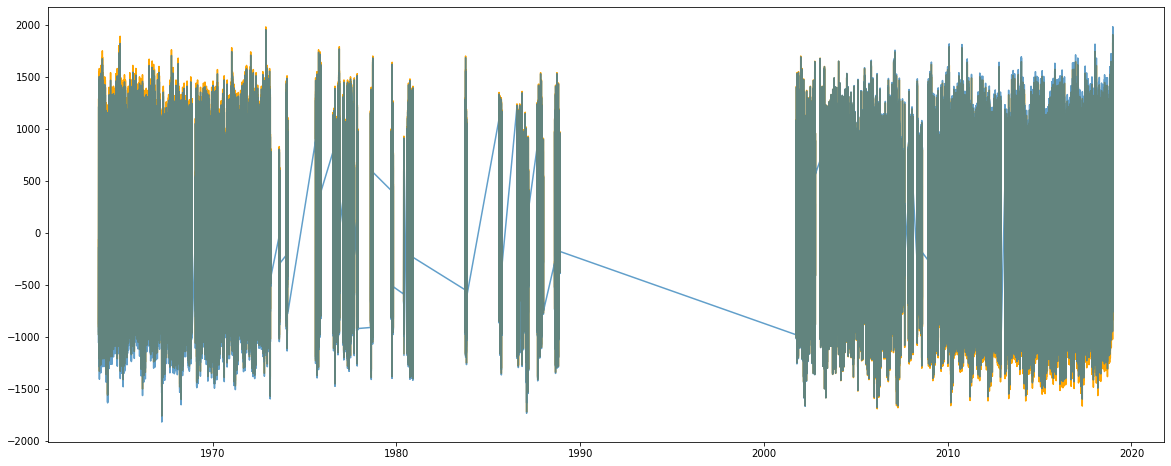

In [143]:
# visualize the detrended data

fig, ax = plt.subplots(figsize=(20,8))

# original data plots in orange
ax.plot(gage_data['datetime'], gage_data['h_mean_corr'], c='orange') 

# detrended data plotted in blue with the opacity dialed back to see the overlapping regions
ax.plot(x_num[valid], h_tr, alpha=0.7) 

plt.show()

Subtract the detrended data from the mean corrected data: $h_2(t) = h_{tide} + h' - h_0 - h_{trend}$

In [144]:
# popt is a tuple
# break out into two variables

m = popt[0]
b = popt[1]

In [145]:
# subtract detrended data

detrend_y = y_height - (m*x_num + b)

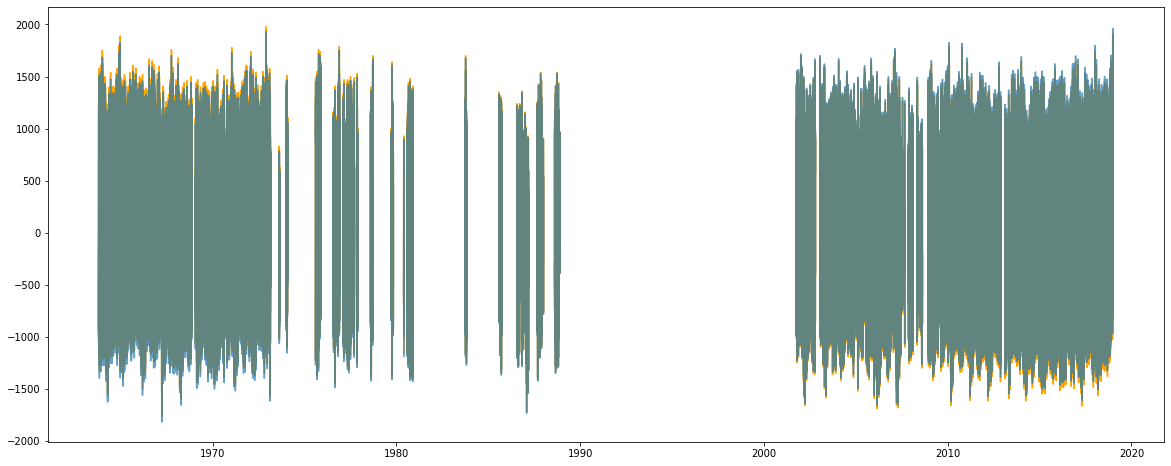

In [146]:
# visualize the detrended data

fig, ax = plt.subplots(figsize=(20,8))

# original data plots in orange
ax.plot(gage_data['datetime'], gage_data['h_mean_corr'], c='orange') 

# detrended data plotted in blue with the opacity dialed back to see the overlapping regions
ax.plot(gage_data['datetime'], detrend_y, alpha=0.7) 

plt.show()

The detrended data looks correct, so add it back to the DataFrame

In [147]:
# add the gauge height, now corrected for both h_0 and h_tr, to the df

gage_data['h_2'] = detrend_y

In [148]:
gage_data.head()

,year,month,day,hour,height,datetime,h_mean_corr,h_2
0,1963,10,17,5,530.0,1963-10-17 05:00:00,-901.151418,-967.183798
1,1963,10,17,6,650.0,1963-10-17 06:00:00,-781.151418,-847.183545
2,1963,10,17,7,970.0,1963-10-17 07:00:00,-461.151418,-527.183292
3,1963,10,17,8,1380.0,1963-10-17 08:00:00,-51.151418,-117.183039
4,1963,10,17,9,1870.0,1963-10-17 09:00:00,438.848582,372.817214


***

Next step is to split the data into two sections, one early and one late in the record, and try out the tidal fit model.

In [149]:
# arbitrarily define a range of dates to view in the timeseries
# adjust these values + display on the plot below to set the bounds on the chunk

lim_min = datetime(1963, 10, 17, 5)
lim_max = datetime(1973, 3, 1, 3)

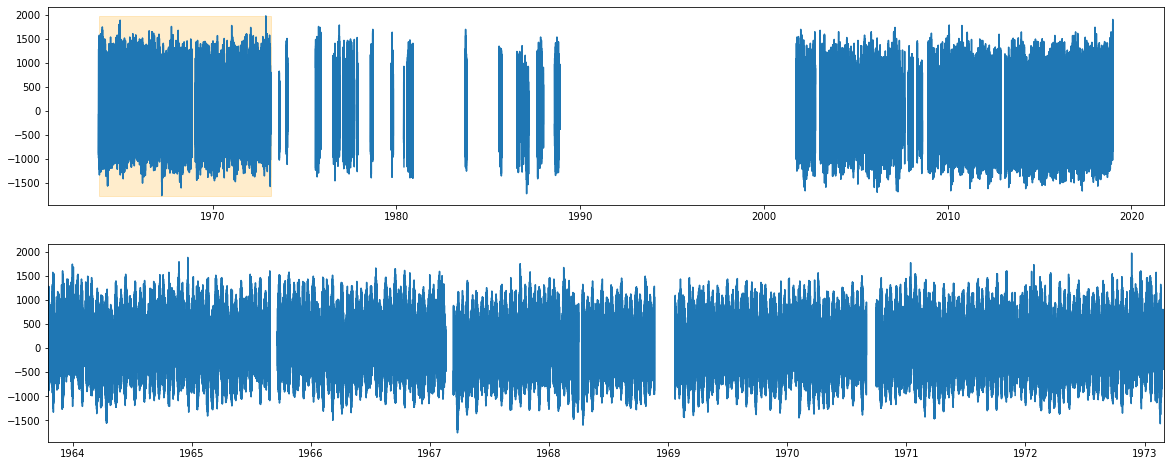

In [150]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(20,8))


# full timeseries fig
ax.plot(gage_data['datetime'], gage_data['h_mean_corr'])

# shade region corresponding to the zoomed in plot
xlims = (lim_min, lim_max)
ax.fill_between(xlims, gage_data['h_mean_corr'].min(), gage_data['h_mean_corr'].max(), 
                alpha=0.2, color='orange')

#zoomed in
ax1.plot(gage_data['datetime'], gage_data['h_mean_corr'])
ax1.set_xlim(lim_min, lim_max)

plt.show()

Isolate the "early chunk" of the record, which is fairly continuous from October, 17th 1963 to March 1st, 1973

In [163]:
# find the index value corresponding to lim_min & lim_max

gage_data.index[gage_data['datetime'] == lim_max].tolist()

[82150]

I tried this timeframe ^ but the model fails to fit. It turns out to be a missing data issue. If I clip the data to the first missing value (below) the tidal model will fit the data:

In [207]:
# store row numbers corresponding to missing data in array

data_breaks = np.where(gage_data['height'] == -32767)
# row 2568 is the first break in the record

In [208]:
# create first chunk from the index values

first_chunk = gage_data.loc[0:2567, :]

In [269]:
# check the chunk

first_chunk.tail()

,year,month,day,hour,height,datetime,h_mean_corr,h_2
2563,1964,2,1,0,1980.0,1964-02-01 00:00:00,548.848582,483.464569
2564,1964,2,1,1,2230.0,1964-02-01 01:00:00,798.848582,733.464822
2565,1964,2,1,2,2270.0,1964-02-01 02:00:00,838.848582,773.465075
2566,1964,2,1,3,1980.0,1964-02-01 03:00:00,548.848582,483.465328
2567,1964,2,1,4,1540.0,1964-02-01 04:00:00,108.848582,43.465581


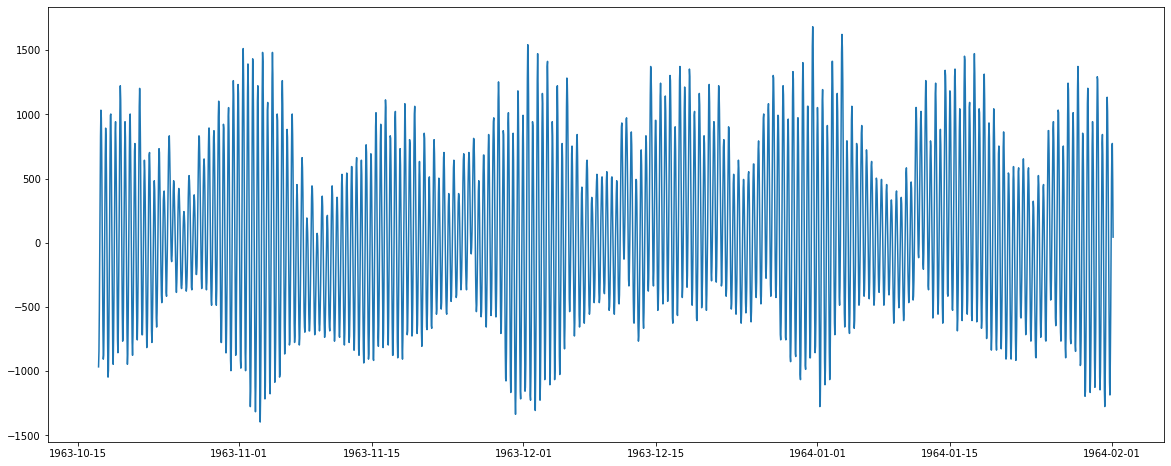

In [210]:
# plot the chunk

fig, ax = plt.subplots(figsize=(20,8))

ax.plot(first_chunk['datetime'], first_chunk['h_2'])

plt.show()

***
Tidal fit model:
Adopting code from the example doc in the pytides github: https://github.com/sam-cox/pytides/wiki/Example-Pytides-Usage

In this section, we generate a datetime array over which tide height predictions will be made. I selected the first week after the break in continuous data collection here. The predictions are being made for just one week in the future.

In [275]:
# Prepare a list of datetimes, each 6 minutes apart, for a week.
# start with the week that the gauge is up and running again, after shutting down on Feb 1st, 1964

prediction_t0 = datetime(1964,2,5, 5) # (year, month, day)
prediction_t0 # the start date of the prediction

datetime.datetime(1964, 2, 5, 5, 0)

In [276]:
# create an array of seconds spanning a 7 week timeframe

hours = 0.1*np.arange(7 * 24 * 10)
hours

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.677e+02, 1.678e+02,
       1.679e+02])

In [277]:
# create an array of datetime values in seconds for one week beginning at t0

times = Tide._times(prediction_t0, hours)
times

array([datetime.datetime(1964, 2, 5, 5, 0),
       datetime.datetime(1964, 2, 5, 5, 6),
       datetime.datetime(1964, 2, 5, 5, 12), ...,
       datetime.datetime(1964, 2, 12, 4, 42),
       datetime.datetime(1964, 2, 12, 4, 48),
       datetime.datetime(1964, 2, 12, 4, 54)], dtype=object)

Here, we fit the harmonic model to the corrected tide gauge data stored in chunk one:

In [278]:
##Fit the tidal data to the harmonic model using Pytides

my_tide = Tide.decompose(first_chunk['h_2'], first_chunk['datetime'])

In [279]:
##Predict the tides using the Pytides model.

my_prediction = my_tide.at(times)

Isolate the predicted timeframe from the tide gauge record, to plot for comparison:

In [280]:
print ("starting index: %s" % (np.where(gage_data['datetime'] == datetime(1964, 2, 5, 5))))
print ("ending index: %s" % (np.where(gage_data['datetime'] == datetime(1964, 2, 12, 4))))

starting index: [2664]
ending index: [2831]


In [281]:
h_vs_predictions = gage_data['h_2'].loc[2664:2831] # .loc slices row by index number
t_vs_predictions = gage_data['datetime'].loc[2664:2831] # have to cut out a time array as well because the df is in hours and the predictions are in seconds

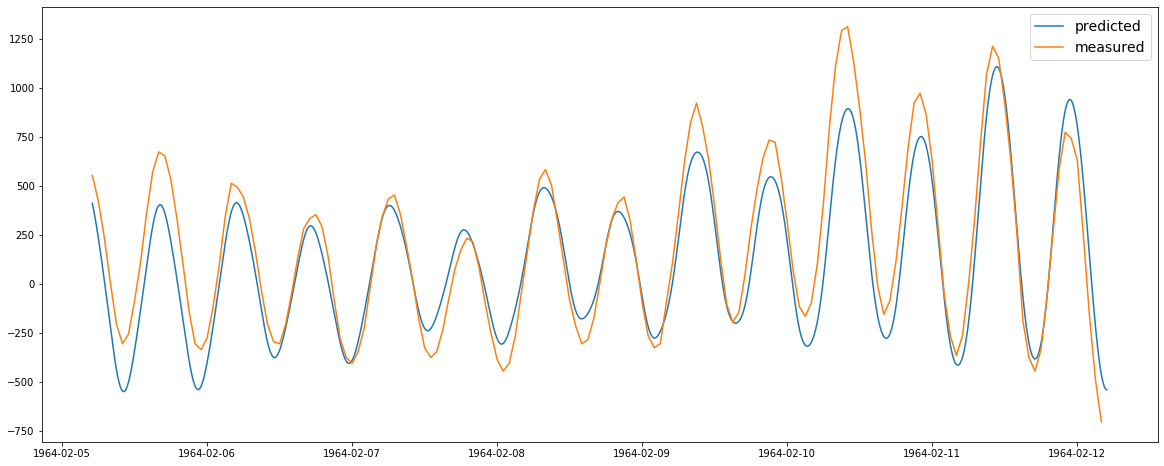

In [282]:
fig, ax = plt.subplots(figsize=(20,8))

# plot the prediction
ax.plot(times, my_prediction, label='predicted')

# plot the corresponding observational record
ax.plot(t_vs_predictions, h_vs_predictions, label='measured')

ax.legend(fontsize=14)

plt.show()

Doing the same process as above, but making a prediction further into the future. Tidal fit model is still run on the same chunk of time, Oct 17th, 1963 to Feb 1st, 1964. For this prediction, targeting about a week prior to the first really long gap in the observation record, which begins on March 1st, 1973

In [283]:
# Prepare a list of datetimes, each 6 minutes apart, for a week.

prediction_t0_ver2 = datetime(1973, 2, 21, 0) # (year, month, day)
prediction_t0_ver2 # the start date of the prediction

datetime.datetime(1973, 2, 21, 0, 0)

In [284]:
# create an array of datetime values in seconds for one week beginning at t0

times_ver2 = Tide._times(prediction_t0_ver2, hours)
times_ver2

array([datetime.datetime(1973, 2, 21, 0, 0),
       datetime.datetime(1973, 2, 21, 0, 6),
       datetime.datetime(1973, 2, 21, 0, 12), ...,
       datetime.datetime(1973, 2, 27, 23, 42),
       datetime.datetime(1973, 2, 27, 23, 48),
       datetime.datetime(1973, 2, 27, 23, 54)], dtype=object)

In [285]:
# note here that variable "my_tide" as NOT changed and is the same model fit used in the prior prediction

my_prediction_ver2 = my_tide.at(times_ver2)

Again, slicing out the corresponding time frame from the observed record

In [288]:
print ("starting index: %s" % (np.where(gage_data['datetime'] == datetime(1973, 2, 21, 0))))
print ("ending index: %s" % (np.where(gage_data['datetime'] == datetime(1973, 2, 27, 23))))

starting index: [81955]
ending index: [82122]


In [289]:
h_vs_predictions_ver2 = gage_data['h_2'].loc[81955:82122] 
t_vs_predictions_ver2 = gage_data['datetime'].loc[81955:82122] 

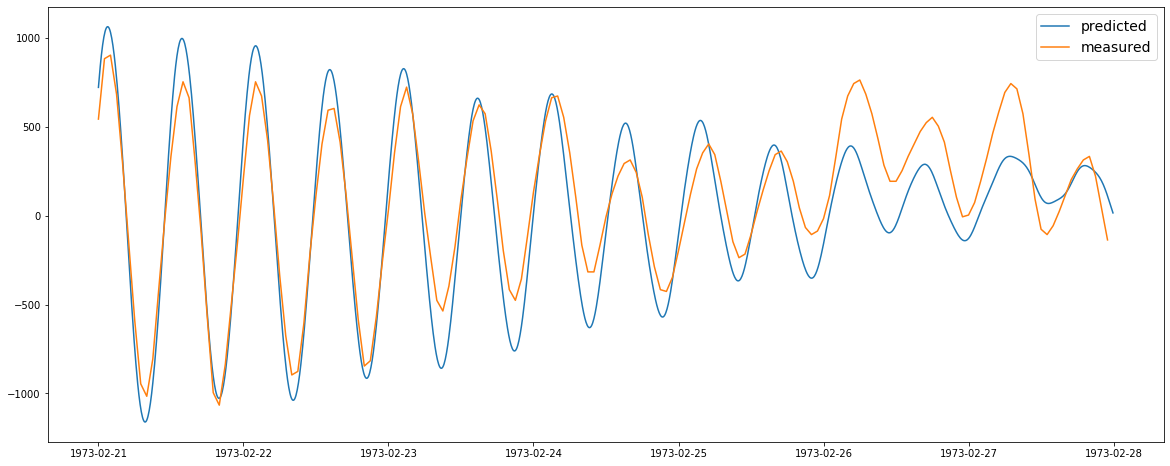

In [290]:
fig, ax = plt.subplots(figsize=(20,8))

# plot the prediction
ax.plot(times_ver2, my_prediction_ver2, label='predicted')

# plot the corresponding observational record
ax.plot(t_vs_predictions_ver2, h_vs_predictions_ver2, label='measured')

ax.legend(fontsize=14)

plt.show()